# Street network Analysis

based on osnmx
goals of the tutorial

- basic concepts of network analysis
- routing
- bearing

based on the open data of:
- OpenStreetMap

requirements
- python knowledge
- geopandas
- openstreetmap

status<br/>
*“My Way”*



note:<br/>
you can also use pandana and the next integration of pyrosm with igraph

---

# Setup
for this tutorial we will use [OSMnx](https://github.com/gboeing/osmnx) = (openstreetmap + [networkx](https://networkx.org/))

Boeing, G. 2017. "[OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks.](https://geoffboeing.com/publications/osmnx-complex-street-networks/)" *Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004*

OSMnx need [rtree](https://toblerity.org/rtree/) a python wrapper to [libspatialindex](https://libspatialindex.org/en/latest/)

... we need to install libspatialindex if not exists on your OS.


In [1]:
try:
  import rtree
except ModuleNotFoundError as e:
  !apt-get install libspatialindex-dev
  !pip install rtree
  import rtree


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 21 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (688 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_

... and now we can install OSMnx

In [1]:
!pip install osmnx

Note: in the case of Colab you neet to restart the runtime (CTRL+M . ) and start from the next line (CTRL+F10)

# Let’s start with OSMnx


In [2]:
import osmnx as ox

## prepare the data

... we can choose the same city used on the last tutorial 

[Mezzolombardo in Italy](https://www.openstreetmap.org/relation/46989#map=13/46.2067/11.1035)

In [3]:
place_name = "Mezzolombardo, Italy"

.. and we can extract all the streets where it's possible to drive

OSMnx creates a overpass query to ask the data inside the area of name of the city and collect all the [highways](https://wiki.openstreetmap.org/wiki/Key:highway) where a car can move

Eg.<br/>
http://overpass-turbo.eu/s/Zid

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/mezzolombardo_streets.png)

In [4]:
G = ox.graph_from_place(place_name, network_type='drive')

OSMnx transform the data from OpenStreetMap in [graph](https://networkx.org/documentation/stable/reference/introduction.html#graphs) for [networkx](https://networkx.org/)

# Graph Theory
text from [wikipedia](https://en.wikipedia.org/wiki/Graph_theory)



A graph is made up of **vertices** (also called *nodes* or *points*) which are connected by **edges** (also called *links* or *lines*)

A distinction is made between undirected graphs, where edges link two vertices symmetrically, and directed graphs, where edges link two vertices asymmetrically;

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Undirected.svg/267px-Undirected.svg.png)

Example<br/>
undirected graph with three nodes and three edges. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Directed.svg/267px-Directed.svg.png)

Example<br/>
a directed graph with three vertices and four directed edges<br/>(the double arrow represents an edge in each direction).


the type of graph generated by OSMnx is a MultiDiGraph: a directed graphs with self loops and parallel edges

more information [here](https://networkx.org/documentation/stable/reference/classes/multidigraph.html)

In [5]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

OSMnx converts the graph from latitude/longitude (WGS83) to the righe UTM coordinate reference system for the area selected

In [6]:
G_proj = ox.project_graph(G)

from osmnx you can create geodataframes (gdfs) from a netxworkx Graph

In [7]:
gdfs = ox.graph_to_gdfs(G_proj)

In [8]:
type(gdfs)

tuple

0 => nodes (points)<br/>
1 => edges (lines)

In [9]:
type(gdfs[0])

geopandas.geodataframe.GeoDataFrame

In [10]:
gdfs[0].geometry.type.unique()

array(['Point'], dtype=object)

In [11]:
gdfs[1].geometry.type.unique()

array(['LineString'], dtype=object)

extract only the nodes (projected)


In [12]:
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)

In [13]:
type(nodes_proj)

geopandas.geodataframe.GeoDataFrame

In [14]:
nodes_proj.crs

<Projected CRS: +proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

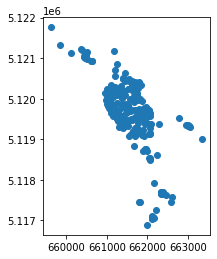

In [15]:
nodes_proj.plot()

In [16]:
lines_proj = ox.graph_to_gdfs(G_proj, nodes=False)

<AxesSubplot:>

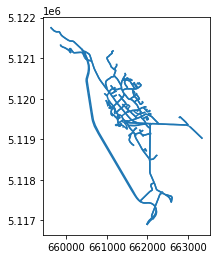

In [17]:
lines_proj.plot()

... and we can use it as a normal geodaframe<br/>

Eg:<br/>
what sized area does our network cover in square meters?

In [18]:
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

7185574.137222286

with OSMnx we can extract some basic statistics 

In [19]:
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'circuity_avg': 1.064879568258031,
 'clean_intersection_count': 122,
 'clean_intersection_density_km': 16.978462356685295,
 'edge_density_km': 9583.241044482424,
 'edge_length_avg': 125.6589215328467,
 'edge_length_total': 68861.08899999999,
 'intersection_count': 193,
 'intersection_density_km': 26.859370777379198,
 'k_avg': 4.264591439688716,
 'm': 548,
 'n': 257,
 'node_density_km': 35.76610512842722,
 'self_loop_proportion': 0.0,
 'street_density_km': 5705.753251868747,
 'street_length_avg': 127.72309345794399,
 'street_length_total': 40999.11300000002,
 'street_segments_count': 321,
 'streets_per_node_avg': 2.5486381322957197,
 'streets_per_node_counts': {0: 0, 1: 64, 2: 1, 3: 179, 4: 13},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.2490272373540856,
  2: 0.0038910505836575876,
  3: 0.6964980544747081,
  4: 0.05058365758754864}}

.. or simple plot directly the graph

or have more complex statitics based on the graph theory

In [20]:
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key in sorted(more_stats.keys()):
    print(key)

avg_neighbor_degree
avg_neighbor_degree_avg
avg_weighted_neighbor_degree
avg_weighted_neighbor_degree_avg
betweenness_centrality
betweenness_centrality_avg
center
closeness_centrality
closeness_centrality_avg
clustering_coefficient
clustering_coefficient_avg
clustering_coefficient_weighted
clustering_coefficient_weighted_avg
degree_centrality
degree_centrality_avg
diameter
eccentricity
pagerank
pagerank_max
pagerank_max_node
pagerank_min
pagerank_min_node
periphery
radius


## Glossary of the terms used by the statistics

For a complete list look the [networkx documentation](https://networkx.org/documentation/stable/)

- **density**<br/>defines the density of a graph. The density is 0 for a graph without edges and 1 for a complete graph. The density of multigraphs can be higher than 1.
- **center**<br/>is the set of points with eccentricity equal to radius.
- **betwnees centrality**<br/>is the number of possible interactions between two non-adjacent points
- **closeness centrality**<br/>is the average distance of a point from all the others
- **clustering coefficient**<br/>the measure of the degree to which points in a graph tend to cluster together
- **degree centrality**<br/>the number of lines incident upon a point 
- **eccentricity** <br/>the eccentricity of a point in a graph is defined as the length of a longest shortest path starting at that point
- **diameter**<br/>the maximum eccentricity
- **edge connectivity**<br/>
is equal to the minimum number of edges that must be removed to disconnect a graph or render it trivial.
- **node connectivity**<br/>
is equal to the minimum number of points that must be removed to disconnect a graph or render it trivial.
- **pagerank**<br/>
computes a ranking of the nodes (points) in a graph based on the structure of the incoming links (lines). It was originally designed as an algorithm to rank web pages.
**periphery**<br/>is the set of nodes with eccentricity equal to the diameter
**radius**<br/>is the minimum eccentricity.

... and we can plot the map

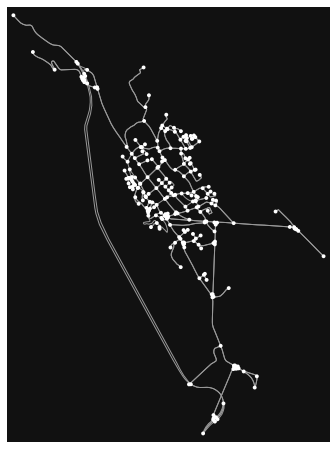

In [21]:
fig, ax = ox.plot_graph(G)

In [22]:
import networkx as nx

In [23]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

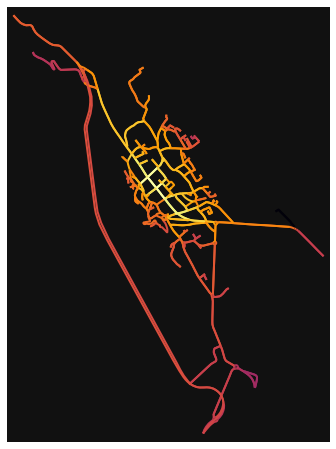

In [24]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

# Find the shortest path between 2 points by minimizing travel time


## calculate the travel time for each edge

### define the origin and destination

... for exampe the highschool and the train stationg of Mezzolombardo


**highschool**

https://www.openstreetmap.org/?mlat=46.21751&mlon=11.09344#map=17/46.21751/11.09344

lat: 46.21751<br/>
lon: 11.09344


**train station**

https://www.openstreetmap.org/?mlat=46.2133&mlon=11.0934#map=16/46.2133/11.0934

lat: 46.2133<br/>
lon: 11.0934





### map matcher

thes two points are NOT on the graph.

We need to find the nodes nearest

In [25]:
point_school =  (46.21751, 11.09344)
point_trainstation = (46.2133, 11.0934)

In [26]:
point_nearest_school = ox.get_nearest_node(G, point_school)
point_nearest_trainstation = ox.get_nearest_node(G, point_trainstation)

### calculate the time to walk over each edges

In [27]:
G = ox.graph_from_place(place_name, network_type='walk')

In [28]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

... geopandas investigation

In [29]:
edges = ox.graph_to_gdfs(G,edges=True,nodes=False)

In [30]:
edges.head(3)

,osmid,ref,name,highway,maxspeed,oneway,length,speed_kph,travel_time,geometry,service,junction,bridge,access,tunnel,u,v,key
0,30275775,SS43,Strada Statale della Val di Non,secondary,50,False,33.870,50.0,2.4,"LINESTRING (11.10212 46.20870, 11.10256 46.20868)",NaN,NaN,NaN,NaN,NaN,82450966,1669326208,0
1,30275775,SS43,Strada Statale della Val di Non,secondary,50,False,72.163,50.0,5.2,"LINESTRING (11.10212 46.20870, 11.10154 46.208...",NaN,NaN,NaN,NaN,NaN,82450966,268811327,0
2,34257473,NaN,NaN,service,NaN,False,14.375,24.3,2.1,"LINESTRING (11.10212 46.20870, 11.10205 46.208...",parking_aisle,NaN,NaN,NaN,NaN,82450966,392889118,0


In [31]:
edges.columns

Index(['osmid', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'length',
       'speed_kph', 'travel_time', 'geometry', 'service', 'junction', 'bridge',
       'access', 'tunnel', 'u', 'v', 'key'],
      dtype='object')

In [32]:
edges[edges.travel_time == edges.travel_time.max()].name

2483    NaN
2687    NaN
Name: name, dtype: object

In [33]:
edges[edges.travel_time == edges.travel_time.max()].osmid

2483    660422718
2687    660422718
Name: osmid, dtype: object

https://www.openstreetmap.org/way/34004791

## find the shortest path between the trainstation and the school 

In [34]:
route = ox.shortest_path(G, point_nearest_trainstation, point_nearest_school, weight='travel_time')

In [35]:
route

[388416104,
 885639428,
 1305986901,
 1305986871,
 2274146551,
 937561848,
 861050486,
 1168688867,
 861049754,
 388416092,
 861049817,
 1168688982,
 276977978,
 276977352,
 276977351,
 331259712,
 1168689199,
 1168688986,
 331259708,
 276977130,
 973022445,
 2249094490,
 276977119]

In [36]:
G[388416104]

AdjacencyView({885639428: {0: {'osmid': 28881638, 'name': 'Via San Francesco', 'highway': 'residential', 'oneway': False, 'length': 3.771, 'speed_kph': 10.0, 'travel_time': 1.4}}, 388416101: {0: {'osmid': 80400799, 'oneway': False, 'name': 'Via San Francesco', 'highway': 'residential', 'length': 62.319, 'speed_kph': 10.0, 'travel_time': 22.4}}, 885639383: {0: {'osmid': 179318888, 'name': 'Via Arturo De Varda', 'highway': 'residential', 'oneway': False, 'length': 64.554, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f4a338ab860>, 'speed_kph': 10.0, 'travel_time': 23.2}}})

In [37]:
edges[edges.u.isin(route)]

,osmid,ref,name,highway,maxspeed,oneway,length,speed_kph,travel_time,geometry,service,junction,bridge,access,tunnel,u,v,key
108,42293674,NaN,NaN,residential,NaN,False,36.217,10.0,13.0,"LINESTRING (11.09323 46.21839, 11.09359 46.21860)",NaN,NaN,NaN,NaN,NaN,276977119,527734693,0
109,25414040,NaN,Via Giorgio Perlasca,residential,NaN,False,34.547,10.0,12.4,"LINESTRING (11.09323 46.21839, 11.09317 46.218...",NaN,NaN,NaN,NaN,NaN,276977119,2249094490,0
110,25414040,NaN,Via Giorgio Perlasca,residential,NaN,False,60.521,10.0,21.8,"LINESTRING (11.09323 46.21839, 11.09320 46.218...",NaN,NaN,NaN,NaN,NaN,276977119,276977118,0
111,25414040,NaN,Via Giorgio Perlasca,residential,NaN,False,7.986,10.0,2.9,"LINESTRING (11.09404 46.21657, 11.09405 46.21665)",NaN,NaN,NaN,NaN,NaN,276977130,973022445,0
112,26286316,NaN,Via Rotaliana,tertiary,NaN,False,12.492,52.0,0.9,"LINESTRING (11.09404 46.21657, 11.09420 46.21657)",NaN,NaN,NaN,NaN,NaN,276977130,527734678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,25414040,NaN,Via Giorgio Perlasca,residential,NaN,False,34.547,10.0,12.4,"LINESTRING (11.09315 46.21808, 11.09317 46.218...",NaN,NaN,NaN,NaN,NaN,2249094490,276977119,0
2463,80334024,NaN,NaN,service,NaN,False,5.819,24.3,0.9,"LINESTRING (11.09250 46.21473, 11.09245 46.21477)",NaN,NaN,NaN,NaN,NaN,2274146551,937561848,0
2464,80334024,NaN,NaN,service,NaN,False,30.744,24.3,4.6,"LINESTRING (11.09250 46.21473, 11.09254 46.214...",NaN,NaN,NaN,NaN,NaN,2274146551,937562241,0
2465,"[115648606, 428490935]",NaN,NaN,footway,NaN,False,47.996,37.0,4.7,"LINESTRING (11.09250 46.21473, 11.09247 46.214...",NaN,NaN,NaN,NaN,NaN,2274146551,1305986871,0


In [38]:
ox.plot_route_folium(G,route,popup_attribute='name',tiles='OpenStreetMap')

how long is our route in meters?

In [39]:
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
sum(edge_lengths)

753.9340000000001

how many minutes does it take?

In [40]:
import datetime

In [41]:
edge_times = ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')
seconds = sum(edge_times)

In [42]:
str(datetime.timedelta(seconds=seconds))

'0:02:03.400000'

## calculate bearing

Calculate the compass bearing from origin node to destination node for each edge in the directed graph then add each bearing as a new edge attribute. Bearing represents angle in degrees (clockwise) between north and the direction from the origin node to the destination node.
<br/><br/>


In [43]:
import geopandas as gpd
import folium

In [44]:
cols = ['city']
names = [('Roma'),('Trento'),('Genova'),('Trieste')]
cities = gpd.GeoDataFrame(names,columns=cols)
geo_cities = gpd.tools.geocode(cities.city, provider="arcgis")

In [45]:
geo_cities

,geometry,address
0,POINT (12.49565 41.90322),Roma
1,POINT (11.11926 46.07005),Trento
2,POINT (8.93898 44.41039),Genova
3,POINT (13.77269 45.65757),Trieste


In [46]:
y = geo_cities.unary_union.centroid.y
x = geo_cities.unary_union.centroid.x

In [47]:
map = folium.Map([y,x], zoom_start=7,tiles='cartodbpositron')

In [48]:
folium.GeoJson(geo_cities.to_json()).add_to(map)

In [49]:
map

In [50]:
trento = geo_cities[geo_cities.address == 'Trento'].geometry

In [51]:
trento_point = (trento.geometry.y.values[0],trento.geometry.x.values[0])

In [52]:
roma_point = (geo_cities[geo_cities.address == 'Roma'].geometry.y.values[0], geo_cities[geo_cities.address == 'Roma'].geometry.x.values[0])
genova_point = (geo_cities[geo_cities.address == 'Genova'].geometry.y.values[0], geo_cities[geo_cities.address == 'Genova'].geometry.x.values[0])
trieste_point = (geo_cities[geo_cities.address == 'Trieste'].geometry.y.values[0], geo_cities[geo_cities.address == 'Trieste'].geometry.x.values[0])

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Compass_Card_B%2BW.svg/480px-Compass_Card_B%2BW.svg.png)

In [53]:
#Trento - Roma
ox.bearing.get_bearing(trento_point,roma_point)

166.14902805108795

In [54]:
#Trento - Trieste
ox.bearing.get_bearing(trento_point,trieste_point)

101.62950188064787

In [55]:
#Trento - Genova
ox.bearing.get_bearing(trento_point,genova_point)

223.5479896367596

# Exercise
- identify the shortest path by walk to reach the Castle of Trento from the main train stationg
- identify how many bars you can reach by walking in 5 minutes from the main train station of Trento (tip: isochrones)